In [47]:
!pip install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2020-07-27 10:32:44--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  43.8MB/s    in 0.6s    

2020-07-27 10:32:45 (43.8 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2020-07-27 10:32:46--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200

## Import necessary libraries

In [48]:
import os
import sys
import time
import datetime
import math

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

import warnings
from gensim.models import FastText
warnings.filterwarnings("ignore")

## Load data

In [49]:
pd.options.display.max_colwidth=1000
train_df = pd.read_csv("../input/vietai-dataset/assignment4-data/Assignment4/train.csv")
train_df.head()

,id,text,class
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\nDesert ngọt vừa , không quá ngấy , rất ngon .\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !",1
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ổn . Tuy_nhiên không_gian tầng 1 hơi hẹp . Ngồi cả ra vỉa_hè . Đồ uống ko ngon lămz,0
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi gần 15p mới mang được ly cà_phê ra . Ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại_nữa .,0
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nên phục_vụ chưa tốt . Đồ uống bình_thường ( đặc_biệt khi so với giá_cả ) và ko có gì đặc_sắc cả .",0
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiếp_đãi , tư_vấn và nói_chuyện rất gần_gũi , rất nhiệt_tình .\nBánh thì rất tuyệt , nhân béo , rau_câu không dùng phẩm . Sau_này có dịp sinh_nhật , mình sẽ order mẫu lớn .\nChúc các bạn làm_ăn phát_đạt !",1


In [50]:
print('Number of train samples in total:', len(train_df))
print('Number of positives:', np.sum(train_df['class']==1))
print('Number of negatives:', np.sum(train_df['class']==0))

Number of train samples in total: 27000
Number of positives: 13518
Number of negatives: 13482


Positive review

In [51]:
sample_positive = train_df[train_df['class'] == 1].sample(5)
sample_positive

,id,text,class
9593,bd5993f9,"Kem ơ ̉ đây la ̣ ma ̀ ngon : xx nhi ̀ n sơ qua giô ́ ng y_chang châ ̣ u đâ ́ t thâ ̣ t , phu ̣ c vu ̣ cu ̃ ng nhanh nư ̃ a , chă ́ c ta ̣ i mi ̀ nh tơ ́ i giơ ̀ trưa . Không_gian qua ́ n tuy hơi nho ̉ nhưng đe ̣ p , qua ́ n mơ ̉ nha ̣ c nhe ̣ nhe ̣ dê ̃ nge , ta ̣ o ca ̉ m gia ́ c thoa ̉ i ma ́ i : 3 se ̃ quay la ̣ i da ̀ i da ̀ i .",1
19814,41efe25d,"Quán được không_gian đẹp có_tiếng , nhưng đồ uống không được ngon , phần ăn thì quá nhỏ nhứng chất_lượng cũng tạm được_giá của mr . ket ở hạ long thì rẻ hơn bên bacu . Nơi lí tươing để tụ_họp và chụp hình . Menu đa_dụng . Lẩu trà sữa kêu 2 người no 3 người uống cũng đủ . Mr.ket tùy chỗ pha có lúc ngon lúc dở . View biển đẹp hết chỗ chê . Chụp hình ko gian bên trong cũng ok . Có thang máy_tiện để đi_lại . Nhân_viên chuyên_nghiệp nhanh_nhẹn . Máy_lạnh thoáng mát .",1
13329,27f94002,"Không_gian ở đây dễ_thương lắm cho_dù hơi cũ tí . Hay mở nhạc Nhật nghe lạ_tai . Purin khá ngon , bánh_rán ngon hơn vài chỗ khác . Cả nv cũng dễ_thương . Có_điều làm đồ_ăn hơi lâu nhất_là bánh bạch_tuộc : p",1
6176,cfe6e45a,"Hôm_nay thư ́ 5 mua 2 tă ̣ ng 2 nhe . Ho ́ a đơn 68k la ̣ u đươ ̣ c quay tru ́ ng thươ ̉ ng , tru ́ ng ba ́ nh v nươ ́ c ha ̀ ... Hôm_qua co ́ ngươ ̀ i tru ́ ng IP6s luôn .\n6 ba ́ nh , 2 cafe ma ̀ co ́ 91k thôi .\nChâ ́ t lươ ̣ ng Cafe_Donkin thi ̀ kho ̉ i chê .\nKhông_gian la ̣ i thoa ̉ i ma ́ i .",1
310,2abb9137,"• GĐ mình ghé quán tối hôm_qua , CN nên hầu_như ai đến cũng phải xếp_hàng khá lâu .\n• Lần nào ghé quán mình cũng chỉ ăn mỗi món Beefsteak , lý_do vì phần sốt tiêu đậm chất Âu & phần bò mềm , màu đẹp nhưng bên trong miếng bò vẫn còn đỏ - đạt đúng chuẩn beefsteak Âu ! 3 lần ghé quán thì được thử 3 kiểu khoai_tây khác_nhau . Nhân_viên lần này phục_vụ nhanh_nhẹn hơn\n• Cơ_mà quán vẫn ồn_ào như ngày nào . Điểm trừ này là do khách rồi ... Bản_thân mình Đi quán Âu mà ồn_ào thì mình cảm_thấy rất khó_chịu , mất hết phong_cách Âu !",1


Negative review

In [52]:
sample_negative = train_df[train_df['class'] == 0].sample(5)
sample_negative

,id,text,class
12973,f660dbc7,giá ở đây cũng nganh với các tiệm fastfood khác but miếng gà bé tí_ti . . nhân_viên thì k biết tư_vấn cho khách là nên ăn thế_nào khuyến_mãi có j . . món ăn thì ngon nhưng cách phục_vụ nhân_viên làm mình bực_bội lắm,0
13656,5bcf5597,"Quán bình_dân nhưng giá_cả nhà_hàng . Mấy món ếch gì đó rang muối , chả nữa còn nuốt được chứ nồi lẩu riêu sườn gì đó thì không_tài_nào mà nuốt nổi , nhạt_nhẽo đến nản . phục_vụ thì siêu chậm , đợi rất rất lâu sau khi gọi món mới được ăn , quán siêu khó tìm , giá siêu đắt . Chưa bao_giờ đi ăn mà bỏ tiền ra thấy tiếc dữ_dội như_vậy . Buồn lắm luôn . Không_gian nhỏ hẹp , có cảm_giác dân_dã nhưng ăn_không ngon_miệng nên không thấy thú_vị lắm . Lúc nhìn cái hóa_đơn cũng hơi hoảng may_mà đi đông chứ đi ít có mà khóc",0
14466,535dae9a,"Nước thì tạm đc .\nĐồ_ăn ko ngon . Cơm cuộn ăn lạ_lạ . Tok gà theo mình thì dở , ngán dễ_sợ @ @ @ @\nGiá thì hơi chát . Gửi xe 4k - _ -",0
20719,a40f848d,"Quán ghi mở_cửa từ 11am-nửa đêm mà mình đến lúc hơn 2h chiều thì ngưng nhận khách , nói 16 : 30 quay lại . Mình quay lại lúc 16 : 30 thì nói bây_giờ mới bắt_đầu nấu đồ_ăn , 17h món mới lên . Ok luôn . Ngồi chờ uống nước đói rã ruột đến 17h thì nói giờ này bếp mới nấu , ngồi chờ dài cổ thêm gần 30 ' nữa mới có đồ_ăn .\nMình gọi 2 phần gà và 1 ba_chỉ nướng . Ba_chỉ thì ok . Gà thì dù đói muốn chết rồi vẫn k thấy ngon gì . Như nhiều bạn nói thì thua Lotteria mà mắc hơn nhiều .\nKhông_gian quán thì như pub , hơi tối và trang_trí lôn xộn . Phục_vụ thì lịch_sự đó nhg mà mấy giờ thì nói vậy , đừng để khách vô chờ cả tiếng .",0
7469,ab484628,ghé vào quán với tần_suất hơi cao ^ ^ giá rẻ .,0


Load pd for submission (test data)

In [53]:
test_df = pd.read_csv("../input/vietai-dataset/assignment4-data/Assignment4/test.csv")
print('Number of test samples in total:', len(test_df))
test_df.head()

Number of test samples in total: 3000


,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\nKhuyết điểm :\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"


Word vector taken from: https://fasttext.cc/docs/en/crawl-vectors.html

In [54]:
words_list = np.load('../input/vietai-dataset/assignment4-data/Assignment4/words_list.npy')
print('Prunned vocabulary loaded!')
words_list = words_list.tolist()
word_vectors = np.load('../input/vietai-dataset/assignment4-data/Assignment4/word_vectors.npy')
word_vectors = np.float32(word_vectors)
print ('Word embedding matrix loaded!')
print('Size of the vocabulary: ', len(words_list))
print('Size of the word embedding matrix: ', word_vectors.shape)

Prunned vocabulary loaded!
Word embedding matrix loaded!
Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


Convert word_list to word2idx dictionary for fast access

In [55]:
word2idx = {w:i for i,w in enumerate(words_list)}
print(list(word2idx.items())[:10])

[('ăm', 0), ('sửng_sốt', 1), ('có_học', 2), ('việc_làm', 3), ('vanila', 4), ('260000', 5), ('linh_chi', 6), ('chảy_máu', 7), ('cũ_kĩ', 8), ('chính_thức', 9)]


In [56]:
word2idx['UNK']

19898

Clean sentence from special characters

In [57]:
# Loại bỏ các dấu câu, dấu ngoặc, chấm than chấm hỏi, vân vân..., chỉ chừa lại các kí tự chữ và số
import re
# re = regular expressions
strip_special_chars = re.compile("[^\w0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [58]:
def get_sentence_indices(sentence, max_seq_length, _words_list):
    """
    Get index of each word in the sentence. Only letters, can be uppercase.
    
    Parameters
    ----------
    sentence: string
        Sentence that needs to process
    max_seq_length: int
        Max number of words in the sentence
    _words_list: list
        a copy of words_list
    """
    indices = np.zeros((max_seq_length), dtype='int32')
    
    # Lowercase and split the sentence into words
    words = [word.lower() for word in sentence.split()]
    
    # Get "unk" index
    unk_idx = word2idx['UNK']
    ### TODO 1 ###
    # Write code that fills the i-th index in "indices" with the i-th index in the "words"
    # NOTE: len(indices) can be shorter than len(words)
    ### START CODE HERE ###
    for idx, word in enumerate(words):
        if idx >= max_seq_length:
            break
        try:
            indices[idx] = word2idx[word]
        except:
            indices[idx] = unk_idx
    ### END CODE HERE ###
    return indices

In [59]:
# Ví dụ:
sentence = "Quán này bé_tí, nhưng siêu cute hạt_me."

# Tiền xử lý câu
sentence = clean_sentences(sentence)
print(sentence)
sentence_indices = get_sentence_indices(sentence, max_seq_length=10, _words_list=words_list)
print(sentence_indices)

quán này bé_tí nhưng siêu cute hạt_me
[11975  8136 19898 18109 10627 12548 19898     0     0     0]


In [60]:
print('Vector representation of sentence: {}'.format(sentence))
print(tf.nn.embedding_lookup(word_vectors,sentence_indices))

Vector representation of sentence: quán này bé_tí nhưng siêu cute hạt_me
tf.Tensor(
[[-0.0027 -0.0843  0.0454 ...  0.0022 -0.1326 -0.0518]
 [ 0.027  -0.0542  0.1437 ... -0.0913  0.0114  0.0132]
 [ 0.063   0.0194 -0.0547 ...  0.0072 -0.0119 -0.0245]
 ...
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]], shape=(10, 300), dtype=float32)


In [61]:
num_words = [len(clean_sentences(x).split()) for x in list(train_df['text'])]
print('The total number of samples is', len(train_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


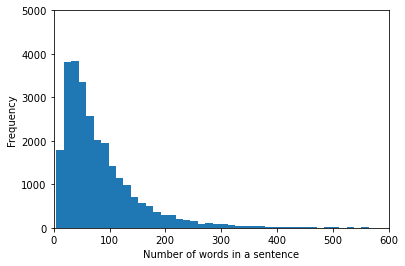

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 100)
plt.xlabel('Number of words in a sentence')
plt.ylabel('Frequency')
plt.axis([0, 600, 0, 5000])
plt.show()

In [63]:
MAX_SEQ_LENGTH = 200

In [64]:
def text2ids(df, max_length, _word_list):
    """
    Transform text in the dataframe into matrix index
    NOTE: this is the train_ids.npy in the dataset
    
    Parameters
    ----------
    df: DataFrame
        dataframe that stores the text
    max_length: int
        max length of a text
    _word_list: numpy.array
        array that stores the words in word vectors
    
    Returns
    -------
    ids: numpy.array
        len(df) * max_length, contains indices of text
    """
    ids = np.zeros((len(df), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(df['text'])):
        ids[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return ids

In [65]:
print("Converting train_df to train_ids...")
train_ids = text2ids(train_df, MAX_SEQ_LENGTH, words_list)
np.save('train_ids.npy', train_ids)

Converting train_df to train_ids...


In [66]:
print('Word indices of the first review: ')
print(train_ids[0])

Word indices of the first review: 
[10774 11975  4826  7446  6880 10642  5767 18584 11975  7090  5284  8591
 15213 18109 10642 11022  4690 11975 16032 10630  2465 14595  2750  8231
  2563 10627  7733  9133  3513 19798  2876 10627  1047 12844 13512  7555
 14312 13245  3961   376 19772 15253 16614 17330 17016 10642 14598 15341
  3913 19519  9334 15522 13952 13245  5596 15221 12109 14341 14017   556
 17115 19151 18839 10346  9076 18584 11975  3364     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

In [177]:
# train_x, test_validation_x, train_y, test_validation_y  = train_test_split(train_ids, 
#                                                                            train_df['class'], test_size=0.2, random_state=2019)

train_x, validation_x, train_y, validation_y  = train_test_split(train_ids, train_df['class'], test_size=0.2)

# validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, 
#                                                               test_validation_y, test_size=0.5, random_state=2018)

In [178]:
BATCH_SIZE = 256

In [179]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
validation_dataset = validation_dataset.batch(BATCH_SIZE)


In [180]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('X =',x)
        print('y =',y)
print("Total: ", idx)

X = tf.Tensor(
[[ 2326  8136  5284 ...     0     0     0]
 [ 9818 10871  5706 ...     0     0     0]
 [11975 18393  2463 ...     0     0     0]
 ...
 [10852  1819  6915 ...     0     0     0]
 [ 5596  5767 11895 ...     0     0     0]
 [10774 11975   255 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor(
[1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1
 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1
 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1
 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0], shape=(256,), dtype=int64)
Total:  84


In [181]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

In [182]:
num_classes = 2 # Binary output
lstm_output_dim = 64
epochs=100

In [183]:
# F1 score and Acc callback, when it reaches a threshold
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("get_f1") is not None:
            max_allowed = 0.98
            if(logs.get("get_f1") > max_allowed):
                print("\nReached {}% f1_score so cancelling training!".format(max_allowed))
                self.model.stop_training = True
class AccScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("acc") is not None:
            max_allowed = 0.98
            if(logs.get("acc") > max_allowed):
                print("\nReached {}% acc so cancelling training!".format(max_allowed))
                self.model.stop_training = True
                
f1_score_callback = F1ScoreCallback()
acc_callback = AccScoreCallback()
model_cp = tf.keras.callbacks.ModelCheckpoint("weight_model.h5", 
                                              monitor="val_get_f1", save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_get_f1", 
                                              patience = epochs/10, restore_best_weights=True)

In [184]:
word_vectors.shape

(19899, 300)

In [185]:
# Test with simple FNN
def create_test_model_1():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(word_vectors.shape[0], word_vectors.shape[1], name="embedding", 
                                  embeddings_initializer=tf.keras.initializers.Constant(word_vectors), trainable=False),
        tf.keras.layers.GRU(lstm_output_dim, dropout=0.42),
        tf.keras.layers.Dense(word_vectors.shape[1]*3, activation="tanh"),
        tf.keras.layers.Dense(word_vectors.shape[1]*2, activation="tanh"),
        tf.keras.layers.Dense(word_vectors.shape[1], activation="tanh"),
        tf.keras.layers.Dense(word_vectors.shape[1]*0.5, activation="tanh"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=[get_f1, "accuracy"])
    return model


In [189]:
def create_test_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(word_vectors.shape[0], word_vectors.shape[1], name="embedding", 
                                  embeddings_initializer=tf.keras.initializers.Constant(word_vectors), trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_output_dim, return_sequences=True), name="bidi_lstm_1"),
        tf.keras.layers.Dropout(0.42, name="dropout_1"),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_output_dim//2), name="bidi_lstm_2"),
        tf.keras.layers.Dropout(0.42, name="dropout_2"),
        tf.keras.layers.Dense(lstm_output_dim, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1_l2(), name="dense_1"),
        tf.keras.layers.Dropout(0.42, name="dropout_3"),
        tf.keras.layers.Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.l1_l2(), name="dense_2"),
        tf.keras.layers.Dropout(0.42, name="dropout_4"),
        tf.keras.layers.Dense(64, activation='tanh', name="dense_3"),
        tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=[get_f1])
    return model

In [190]:
test_1=False

if test_1:
    model = create_test_model_1()
else:
    model = create_test_model()
    
model.summary()


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         5969700   
_________________________________________________________________
bidi_lstm_1 (Bidirectional)  (None, None, 128)         186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidi_lstm_2 (Bidirectional)  (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)              

In [191]:
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[f1_score_callback,
                                                                                              acc_callback,
                                                                                              model_cp])

Epoch 1/100
85/85 [==============================] - 9s 105ms/step - loss: 8.7288 - get_f1: 0.6581 - val_loss: 4.4984 - val_get_f1: 0.8183
Epoch 2/100
85/85 [==============================] - 8s 92ms/step - loss: 2.3715 - get_f1: 0.8017 - val_loss: 0.9745 - val_get_f1: 0.7369
Epoch 3/100
85/85 [==============================] - 8s 91ms/step - loss: 0.6470 - get_f1: 0.8219 - val_loss: 0.5152 - val_get_f1: 0.8357
Epoch 4/100
85/85 [==============================] - 8s 90ms/step - loss: 0.5277 - get_f1: 0.8148 - val_loss: 0.4751 - val_get_f1: 0.8117
Epoch 5/100
85/85 [==============================] - 8s 90ms/step - loss: 0.5040 - get_f1: 0.8234 - val_loss: 0.4619 - val_get_f1: 0.8414
Epoch 6/100
85/85 [==============================] - 8s 90ms/step - loss: 0.4745 - get_f1: 0.8370 - val_loss: 0.4469 - val_get_f1: 0.8435
Epoch 7/100
85/85 [==============================] - 8s 90ms/step - loss: 0.4571 - get_f1: 0.8425 - val_loss: 0.4296 - val_get_f1: 0.8431
Epoch 8/100
85/85 [==============

Epoch 60/100
85/85 [==============================] - 8s 90ms/step - loss: 0.2022 - get_f1: 0.9528 - val_loss: 0.5502 - val_get_f1: 0.8664
Epoch 61/100
85/85 [==============================] - 8s 90ms/step - loss: 0.1897 - get_f1: 0.9560 - val_loss: 0.5005 - val_get_f1: 0.8613
Epoch 62/100
85/85 [==============================] - 8s 91ms/step - loss: 0.1970 - get_f1: 0.9559 - val_loss: 0.5060 - val_get_f1: 0.8637
Epoch 63/100
85/85 [==============================] - 8s 90ms/step - loss: 0.1969 - get_f1: 0.9556 - val_loss: 0.5707 - val_get_f1: 0.8570
Epoch 64/100
85/85 [==============================] - 8s 91ms/step - loss: 0.1785 - get_f1: 0.9597 - val_loss: 0.5968 - val_get_f1: 0.8497
Epoch 65/100
85/85 [==============================] - 8s 90ms/step - loss: 0.1911 - get_f1: 0.9558 - val_loss: 0.5254 - val_get_f1: 0.8550
Epoch 66/100
85/85 [==============================] - 8s 91ms/step - loss: 0.1989 - get_f1: 0.9534 - val_loss: 0.6067 - val_get_f1: 0.8470
Epoch 67/100
85/85 [=======

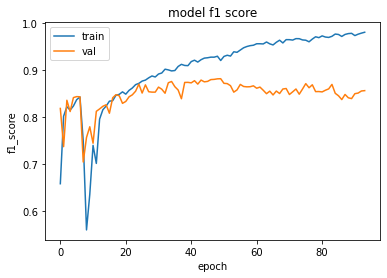

In [192]:
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model f1 score')
plt.ylabel('f1_score')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

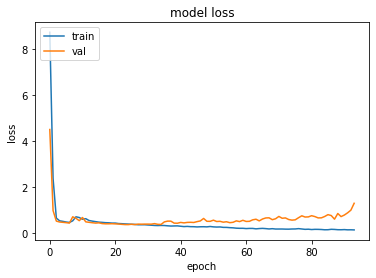

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
model.save_weights("weight_model.h5")

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')
tokenized = []
result = []
threshold = 0.5

for idx, row in test_df.iterrows():
    row = clean_sentences(row.text)
    segmented_list = rdrsegmenter.tokenize(row)
    segmented_sentence = " ".join(item for innerlist in segmented_list for item in innerlist)
    indices = get_sentence_indices(segmented_sentence, MAX_SEQ_LENGTH, words_list)
    input_data = indices.reshape(1, *indices.shape)
    tokenized.append(input_data)

In [ ]:
for ele in tokenized:
    prediction = model.predict(ele)
    result.append(1 if prediction >= threshold else 0)
print(result[:20])
print(tokenized[:20])

In [ ]:
test_df

In [ ]:
submission_df = pd.read_csv("../input/vietai-dataset/assignment4-data/Assignment4/sample_submission.csv")
submission_df["class"] = result
submission_df.head(20)

In [ ]:
submission_df.to_csv("rnn_submission.csv", index=False)